<a href="https://colab.research.google.com/github/DomMc97/Car_Data/blob/master/Discussion/Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Car Data

A comparison of the classification of the quality of a car from a set of descriptors using Random Forest classification, Support Vector Machines and Neural Networks.

The data set contains a record of the rating of a series of cars by a car dealer into the following categories: 'unacceptable', 'acceptable', 'good', or 'very good' this is the target. The data set also contains the following descriptors for each car:

* buying: buying price
* maint: price of the maintenance
* doors: number of doors
* persons: capacity in terms of persons to carry
* lug_boot: the size of luggage boot
* safety: estimated safety of the car

---

## Set Up

Import Libraries

In [17]:
# scientific library
import numpy as np
from scipy.stats import mode

# data analytics library
import pandas as pd

# pytorch functions
from torch import from_numpy
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

# libraries for saving/loading data
import pickle
from google.colab import drive

In [18]:
%%capture
# installs skorch
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

Mount Drive.

In [19]:
# mount drive
drive.mount('/content/drive')

# root of all file paths used in notebook
root = '/content/drive/My Drive/Methods for Data Science/CW2/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importation of processed data.

In [20]:
# upload files
X_train = np.load(root + 'X_train.npy')
y_train = np.load(root + 'y_train.npy')
X_test = np.load(root + 'X_test.npy')
y_test = np.load(root + 'y_test.npy')

In [21]:
# convert X_test to a tensor
t_X_test = from_numpy(X_test).float()

# convert y_trest to a tensor
t_y_test = from_numpy(y_test).long()

Importation of models.

In [22]:
# load RF model
RF = pickle.load(open(root + 'RF.sav', 'rb'))

# load RBF SVM model
SVM = pickle.load(open(root + 'RBF_SVM.sav', 'rb'))

class Drop_NN(nn.Module):
  # define hidden layers with relu activation function
  def __init__(self, dr=0.5, init_run=False):
        super().__init__()
        # input of 6 descriptors to hidden layer weights
        self.W1 = nn.Linear(6, 200)
        # a precusor to hidden layer which performs a dropout with rate dr
        self.dropout = nn.Dropout(p=dr)
        # hidden layer to hidden layer weights
        self.W2 = nn.Linear(200, 200)
        # hidden layer to 4 multi-class outputs
        self.W3 = nn.Linear(200, 4)
        # initilaise weights for consistency
        if init_run:
            save(self.state_dict(), root + 'model_params.sav')
        else:
            self.load_state_dict(load(root + 'model_params.sav'))

  # forward pass through network
  def forward(self, x):
        out = F.relu(self.W1(x))
        out = self.dropout(out)
        out = F.relu(self.W2(out))
        out = F.relu(self.W3(out))
        return out

# load NN model
NN = pickle.load(open(root + 'NN.sav', 'rb'))

## Performance


A function to get the accuracy, precision, recall, f1 score and confusion matrix on the test data set. Since the data set is multiclass precision etc. is the mean of the precision for each label.

In [23]:
def quality(X, y, model):
    """
    Function to get the accuracy, precision, recall, f1 score and confusion 
    matrix of the predictions on a model on the data set.
    Inputs:
        X: Predictor dataset.
        y: Target datset.
        model: Fitted classification model. 
    Outputs:
        score: dict of scores in order in description.
    """
    #makes predictions on training set
    pred = model.predict(X)

    # dict of scores
    scores = {}

    # accuracy metrics
    scores['Accuracy'] = metrics.accuracy_score(y, pred)
    scores['Precision'] = metrics.precision_score(y, pred, average='macro')
    scores['Recall Score'] = metrics.recall_score(y, pred, average='macro')
    scores['F1 Score'] = metrics.f1_score(y, pred, average='macro')
    scores['mat'] = metrics.confusion_matrix(y, pred)

    return scores

Perfomance dictionary of models.

In [24]:
# RF
RF_scores = quality(X_test, y_test, RF)
print(RF_scores)
# SVM
SVM_scores = quality(X_test, y_test, SVM)
print(SVM_scores)
# NN
NN_scores = quality(t_X_test, t_y_test, NN)
print(NN_scores)

{'Accuracy': 0.5262096774193549, 'Precision': 0.47763712706950817, 'Recall Score': 0.4746917668120749, 'F1 Score': 0.47363480757572796, 'mat': array([[292,  38,  44,  38],
       [ 22,  66,  52,  48],
       [ 18,  55,  80,  51],
       [ 13,  40,  51,  84]])}
{'Accuracy': 0.5120967741935484, 'Precision': 0.486886701847219, 'Recall Score': 0.4716463945627828, 'F1 Score': 0.4687610687610688, 'mat': array([[267,  45,  62,  38],
       [ 11,  59,  72,  46],
       [  7,  38, 104,  55],
       [  5,  40,  65,  78]])}
{'Accuracy': 0.4808467741935484, 'Precision': 0.354181239810728, 'Recall Score': 0.4316887310594554, 'F1 Score': 0.3747556349278493, 'mat': array([[269,   0,  40, 103],
       [ 45,   0,  45,  98],
       [ 42,   0,  78,  84],
       [ 19,   0,  39, 130]])}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Display scores.

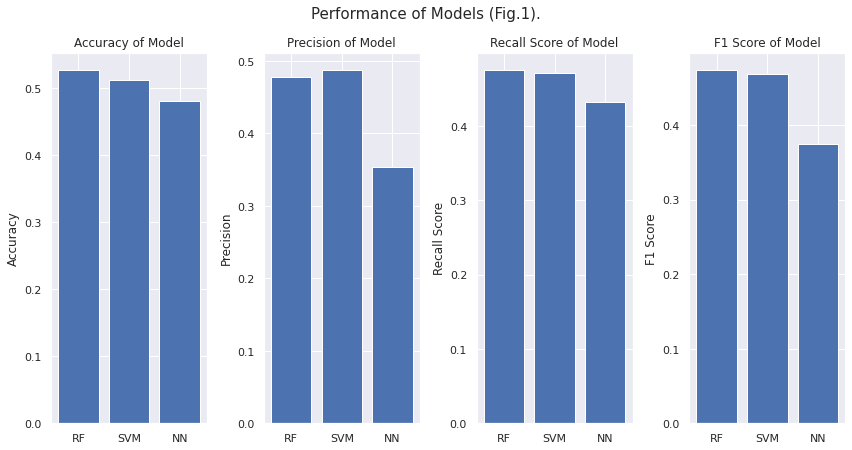

In [25]:
# creates figure
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

# creates figure title
plt.suptitle('Performance of Models (Fig.1).', fontsize='15', y=1.04)

# list of models 
models = ['RF', 'SVM', 'NN']

# pos 
pos = [0, 1, 2]

for ax, key in zip(axs, ['Accuracy','Precision','Recall Score', 'F1 Score']):
    # sets title
    ax.set_title(key + ' of Model')
    
    # sets y_axes titles
    ax.set_ylabel(key)

    # source data
    data = [RF_scores[key], SVM_scores[key], NN_scores[key]]

    #  make plot
    ax.bar(pos, data)
    
    # set tick labels
    ax.set_xticks(pos)
    ax.set_xticklabels(models)

# display
plt.tight_layout()
plt.show()

Confusion matricies.

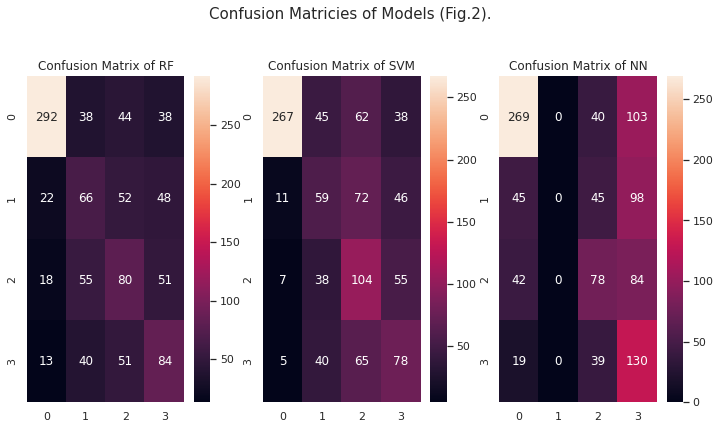

In [26]:
# creates figure
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# creates figure title
plt.suptitle('Confusion Matricies of Models (Fig.2).', fontsize='15', y=1.04)

# matricies
mats = [RF_scores['mat'], SVM_scores['mat'], NN_scores['mat']]

for ax, model, mat in zip(axs, models, mats):
    # sets title
    ax.set_title('Confusion Matrix of ' + model)

    # heatmap
    sns.heatmap(mat, annot=True,fmt='.0f', ax=ax)

plt.show()

## Exploration of the Data Sets

A general observation which can explain the fairly low accuracy of the models on the training data is that for the same unique set of descriptors we get different ratings.

In [27]:
# dataframe of train
df_train = pd.DataFrame(np.hstack((X_train, y_train.reshape(len(y_train), 1))))

# df where the target col is a vector of targets for the same descriptors.
group_train = df_train.groupby([0,1,2,3,4,5])[6].apply(list).reset_index()

# display format
group_train.tail(10)

,0,1,2,3,4,5,6
1190,1.509864,1.716005,1.289805,-0.428909,-0.190199,0.853933,"[0.0, 1.0, 2.0, 3.0]"
1191,1.509864,1.716005,1.289805,-0.428909,1.088411,-1.942747,"[0.0, 1.0, 2.0]"
1192,1.509864,1.716005,1.289805,-0.428909,1.088411,-0.544407,[0.0]
1193,1.509864,1.716005,1.289805,0.992357,-1.468808,-1.942747,"[0.0, 1.0, 1.0, 1.0, 2.0, 2.0]"
1194,1.509864,1.716005,1.289805,0.992357,-1.468808,-0.544407,"[0.0, 2.0, 2.0, 3.0, 3.0]"
1195,1.509864,1.716005,1.289805,0.992357,-1.468808,0.853933,"[0.0, 1.0]"
1196,1.509864,1.716005,1.289805,0.992357,-0.190199,-1.942747,"[0.0, 1.0, 3.0, 3.0]"
1197,1.509864,1.716005,1.289805,0.992357,-0.190199,-0.544407,"[0.0, 2.0, 3.0, 3.0]"
1198,1.509864,1.716005,1.289805,0.992357,-0.190199,0.853933,"[0.0, 1.0, 3.0, 3.0]"
1199,1.509864,1.716005,1.289805,0.992357,1.088411,-1.942747,"[0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0]"


This puts a theoretical limit on the maximum training accuracy, which would be maximised when the prediction is made the modal value for each descriptor set.

In [28]:
def mode_count(row):
    """
    Gets the count of the mode for a target vector.
    """

    # target vector
    vec = row[6]

    # count of the modal predicted class
    _, count =  mode(vec)
    
    return count[0]

# get counts
group_train['count'] = group_train.apply(lambda row: mode_count(row),axis=1)

# maximum accuracy
max_acc = 100*group_train['count'].sum()/len(y_train)

# print result
print('The maximum accuaracy on the training set is %.2f%%'%max_acc)

The maximum accuaracy on the training set is 52.65%


This is also a feature of the test set.

In [29]:
# dataframe of test
df_test = pd.DataFrame(np.hstack((X_test, y_test.reshape(len(y_test), 1))))

# df where the target col is a vector of targets for the same descriptors.
group_test = df_test.groupby([0,1,2,3,4,5])[6].apply(list).reset_index()

# get counts
group_test['count'] = group_test.apply(lambda row: mode_count(row),axis=1)

# maximum accuracy
max_acc = 100*group_test['count'].sum()/len(y_test)

# print result
print('The maximum accuaracy on the test set is %.2f%%'%max_acc)

The maximum accuaracy on the test set is 65.52%


We see however that the theoretical accuracy limit of the test data set is higher than that of training data set. I will conclude the exploration with the finding of the distribution of results in the test data set. 

In [30]:
# count of unique values
unique, counts = np.unique(y_test, return_counts=True)

# print results
for val, count in zip(unique, counts):
    print('Value: ',val,'\t Count:', count)

Value:  0 	 Count: 412
Value:  1 	 Count: 188
Value:  2 	 Count: 204
Value:  3 	 Count: 188


The test set can be seen to be unbalanced in terms of predictors with a biased towards the amount of 0 predictions.


## Discussion

The pattern accuracy of the models on the training data set was continued on the application of the test data set. The optimised Random Forest (RF) model was shown to have the highest accuracy on both data sets of 41.71% and 52.62% respectively. The second highest accuracy was for the optimised  Support Vector Machine (SVM) with a Radial Basis Function (RBF) kernel which had a training accuracy of 41.12% and a test accuracy of 51.21%. The lowest accuracy for both training and test data sets was for the Neural Network (NN) witch accuracy of 34.84% and 48.08% respectively.

The first observation from this is that the accuracy seems to be much higher on the test data set for all the models than on the training data set. There are 2 main reasons for this pattern of improved performance on generalisation. The key factor is due to the presence of contradictory samples in the data sets: samples which have the same descriptors but different targets. There is a higher density of these contradictory points in the training data set compared to the test data set which can be interpterd from it's maximum theoretical accuracy being 13% lower. This inherently restricts the accuracy of the training data set. Another possible reason is the imbalences of the test data set which has a high proportion of ratings of 0 for which the models have a tendency to over predict. 

In general the pattern of the RF model being best is true for all metrics expect for precision for which the SVM has the strongest performance. The reason that the RF and SVM models massively outperform the NN is predominatly due to the batch learning of NN's. The batch learing is conversely affected by the contradictory samples. When the data set is split into batches contradictory samples will be evelnly distributed throughout the batches therefore weights will constantly be adjusted after iterations for different optimum weight loss landscapes depending on which contradictory sample it contains.

The reason that the RF model outpeforms SVM is firstly due to the suitability of the RF models for data sets which have low correlation between descriptors which I have showns is true for the training data set. Another reason for it's suitability is that RF averaging property over many decision tress is an advantageous feature for classification in which the training data set has contradictory samples. Naturally modal targets will become the modal prediction. 